# Resources

- [Blog post](https://medium.com/grabngoinfo/3-ways-for-multiple-time-series-forecasting-using-prophet-in-python-7a0709a117f9) for this notebook
- Video tutorial for this post on [YouTube](https://www.youtube.com/watch?v=1YAEk3v9S-o&list=PLVppujud2yJpVhqR0tqdw1lQPUuplBYM6&index=4)
- More video tutorials on [time series](https://www.youtube.com/playlist?list=PLVppujud2yJpVhqR0tqdw1lQPUuplBYM6)
- More blog posts on [time series](https://medium.com/@AmyGrabNGoInfo/list/time-series-0aba8a92cca1)


For more information about data science and machine learning, please check out my [YouTube channel](https://www.youtube.com/channel/UCmbA7XB6Wb7bLwJw9ARPcYg), [Medium Page](https://medium.com/@AmyGrabNGoInfo) and [GrabNGoInfo.com](https://grabngoinfo.com/tutorials/), or follow GrabNGoInfo on [LinkedIn](https://www.linkedin.com/company/grabngoinfo/).

# Intro

Welcome to GrabNGoInfo! Multiple time series forecasting refers to training many time series models and making predictions. For example, if we would like to predict the sales quantity of 10 products in 5 stores, there will be 50 store-product combinations, and each combination is a time series. Using the multiple time series model, we can train and predict the 50 time series model at the same time. Another example is to predict multiple stock prices at the same time.

In this tutorial, we will predict the stock prices of five tech companies using Prophet. Three ways of running multiple time series forecasting will be demonstrated. You will learn:

* How to run multiple time series forecasting using for loop?
* How to set up multi-processing and utilize all the cores on a computer to run multiple time series models?
* How to set up PySpark to run multiple time series forecasting in parallel?

If you are not familiar with Prophet, please check out my previous tutorial [Time Series Forecasting Of Bitcoin Prices Using Prophet](https://medium.com/grabngoinfo/time-series-forecasting-of-bitcoin-prices-using-prophet-1069133708bc) and [Multivariate Time Series Forecasting with Seasonality and Holiday Effect Using Prophet in Python](https://medium.com/grabngoinfo/multivariate-time-series-forecasting-with-seasonality-and-holiday-effect-using-prophet-in-python-d5d4150eeb57).

Let's get started!

# Step 1: Install and Import Libraries

In the first step, we will install and import libraries.

Three packages are installed:

* `yfinance` is the python package for pulling stock data from Yahoo Finance. 
* `prophet` is the package for the time series model. 
* `pyspark` is for setting up the Spark environment.

In [ ]:
# Install libraries
!pip install yfinance prophet pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 65 kB 4.4 MB/s 
     |████████████████████████████████| 281.4 MB 35 kB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 
     |████████████████████████████████| 6.4 MB 31.6 MB/s 
     |████████████████████████████████| 49 kB 7.7 MB/s 
     |████████████████████████████████| 45 kB 3.8 MB/s 
     |████████████████████████████████| 198 kB 63.2 MB/s 
  Created wheel for prophet: filename=prophet-1.0.1-py3-none-any.whl size=6641162 sha256=037786250b3d0fc27771060b3f712bc371293485ea4c28bc8e0e91b432de58b4
  Stored in directory: /root/.cache/pip/wheels/4e/a0/1a/02c9ec9e3e9de6bdbb3d769d11992a6926889d71567d6b9b67
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=26e2c780ad9a406d5eac05236d4b9d7ef448b2128433ada237ac44a0a5376905
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd


After installing the three python packages, we imported the libraries needed for this tutorial.

* `pandas` and `numpy` are for data processing.
* `yfinance` is for pulling stock price data from Yahoo Finance.
* `prophet` is for building the time series model.
* `seaborn` and `matplotlib` are for visualization.
* `Pool` and `cpu_count` are for multi-processing.
* `pyspark.sql.types`, `pandas_udf`, and `PandasUDFType` are for Spark parallel processing.
* `tqdm` is for generating a process bar to show the completed percentage.
* `time` is for tracking the time used for modeling and prediction.

In [ ]:
# Data processing
import pandas as pd
import numpy as np

# Get time series data
import yfinance as yf

# Prophet model for time series forecast
from prophet import Prophet

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Multi-processing
from multiprocessing import Pool, cpu_count

# Spark
from pyspark.sql.types import *
from pyspark.sql.functions import pandas_udf, PandasUDFType

# Process bar
from tqdm import tqdm

# Tracking time
from time import time


# Step 2: Pull Data

The second step pulls stock data from Yahoo Finance API. We will pull 2 years of daily data from the beginning of 2020 to the end of 2021.

* `start_date = '2020-01-02'` means the earliest date for the stock data is January 2nd of 2020. It did not start with January 1st because January 1st is a holiday, and there is no stock data on holidays and weekends.
* `end_date = '2022-01-01'` means that the last date for the stock data is December 31st of 2021. `yfinance` excludes the end date, so we need to add one day to the last day of the data end date.

In [ ]:
# Data start date
start_date = '2020-01-02'

# Data end date
end_date = '2022-01-01' # yfinance excludes the end date, so we need to add one day to the last day of data

We will download the closing prices for five tickers. FB is for Facebook (Meta), GOOG is for Google, ORCL is for Oracle, MSFT is for Microsoft, and AMZN is for Amazon.

The goal of the time series model is to predict the closing price of all five stocks.



In [ ]:
# Download data
ticker_list = ['FB', 'GOOG', 'ORCL', 'MSFT', 'AMZN']
data = yf.download(ticker_list, start=start_date, end=end_date)[['Close']]

# Drop the top level column name
data.columns = data.columns.droplevel()

# Take a look at the data
data.head()

[*********************100%***********************]  5 of 5 completed


,AMZN,FB,GOOG,MSFT,ORCL
Date,,,,,
2020-01-02,1898.010010,209.779999,1367.369995,160.619995,53.950001
2020-01-03,1874.969971,208.669998,1360.660034,158.619995,53.759998
2020-01-06,1902.880005,212.600006,1394.209961,159.029999,54.040001
2020-01-07,1906.859985,213.059998,1393.339966,157.580002,54.160000
2020-01-08,1891.969971,215.220001,1404.319946,160.089996,54.130001


From the visualization of the stock prices, we can see that all five stocks increase in prices, and Amazon and Google have the highest prices.

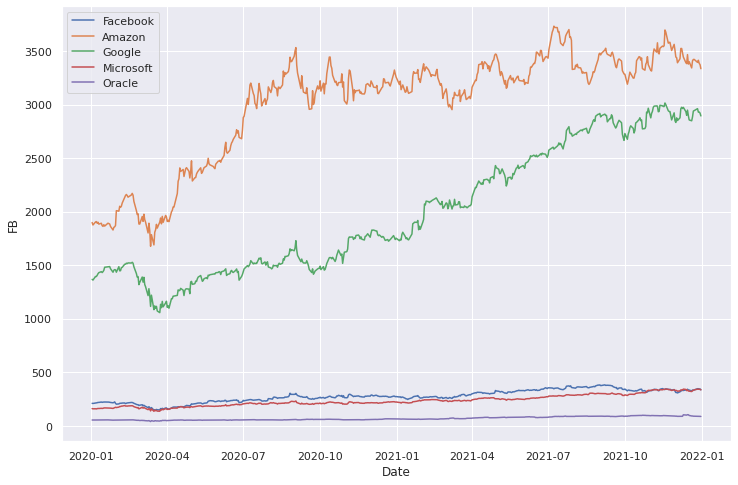

In [ ]:
# Visualize data using seaborn
sns.set(rc={'figure.figsize':(12,8)})
sns.lineplot(x=data.index, y=data['FB'])
sns.lineplot(x=data.index, y=data['AMZN'])
sns.lineplot(x=data.index, y=data['GOOG'])
sns.lineplot(x=data.index, y=data['MSFT'])
sns.lineplot(x=data.index, y=data['ORCL'])
plt.legend(labels = ['Facebook', 'Amazon', 'Google', 'Microsoft', 'Oracle'])

There are 505 data points for each ticker, and there are no missing values.

In [ ]:
# Data information
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 505 entries, 2020-01-02 to 2021-12-31
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AMZN    505 non-null    float64
 1   FB      505 non-null    float64
 2   GOOG    505 non-null    float64
 3   MSFT    505 non-null    float64
 4   ORCL    505 non-null    float64
dtypes: float64(5)
memory usage: 23.7 KB


# Step 3: Data Processing

Step 3 transforms the dataset into a multiple time series model dataset.

Firstly, the dataset is transformed from the wide format to the long format using the pandas `.melt` function.

Prophet requires at least two columns as inputs: a `ds` column and a `y` column.

* The `ds` column has the time information. The column `Date` is renamed to `ds`.
* The `y` column has the time series values. In this example, because we are predicting the closing stock price, y represents the stock close price.
* There is no pre-defined name for the individual time series in prophet, so we can keep the name `ticker` as is.

In [ ]:
# Release Date from the index
data = data.reset_index()

# Change data from the wide format to the long format
df = pd.melt(data, id_vars='Date', value_vars=['AMZN', 'FB', 'GOOG', 'MSFT', 'ORCL'])
df.columns = ['ds', 'ticker', 'y']
df.head()

,ds,ticker,y
0,2020-01-02,AMZN,1898.010010
1,2020-01-03,AMZN,1874.969971
2,2020-01-06,AMZN,1902.880005
3,2020-01-07,AMZN,1906.859985
4,2020-01-08,AMZN,1891.969971


After transforming the dataset from the wide format to the long format, we have 2525 records.

In [ ]:
# Check the dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2525 entries, 0 to 2524
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      2525 non-null   datetime64[ns]
 1   ticker  2525 non-null   object        
 2   y       2525 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 59.3+ KB


Next, we group the pandas dataframe by the column `ticker` and save it in a new dataframe called `groups_by_ticker`. Using `.groups.keys()`, we can confirm that there are five groups, one group for each ticker.

In [ ]:
# Group the data by ticker
groups_by_ticker = df.groupby('ticker')

# Check the groups in the dataframe
groups_by_ticker.groups.keys()

dict_keys(['AMZN', 'FB', 'GOOG', 'MSFT', 'ORCL'])

# Step 4: Define Function

In step 4, the function for training and forecasting each group is defined.

* The input data is an individual time series data for a group.
* `Prophet()` initiates the time series model with the default hyperparameters, and we give the model the name `m`. I will create another tutorial for prophet time series model hyperparameter tuning. Please subscribe to the YouTube channel or Medium email so you will be notified when the video is published.
* `m.fit(group)` fits the prophet model on the individual time series data, which is the stock price data for a ticker.
* `make_future_dataframe` creates a new dataframe called `future` for the forecasting. `periods=15` means that we will forecast for 15 days of data. To use a different frequency, we can specify the `freq` option. For example, `periods=15, freq='MS'` means that we are forecasting for the next 15 months.
* After predicting on the `future` dataframe, prophet produces a long list of outputs. We only kept `ds`, `yhat`, `yhat_lower` and `yhat_upper`. `yhat` is the predicted value. `yhat_lower` and `yhat_upper` are the lower and upper bound of the uncertainty interval.
* A new column called `ticker` is created in the forecast dataframe to indicate the ticker name for the predictions.

The output of the function has 5 columns: `ds`, `ticker`, `yhat`, `yhat_upper`, and `yhat_lower`.


In [ ]:
def train_and_forecast(group):

  # Initiate the model
  m = Prophet()
  
  # Fit the model
  m.fit(group)

  # Make predictions
  future = m.make_future_dataframe(periods=15)
  forecast = m.predict(future)[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
  forecast['ticker'] = group['ticker'].iloc[0]
  
  # Return the forecasted results
  return forecast[['ds', 'ticker', 'yhat', 'yhat_upper', 'yhat_lower']]  

# Step 5: Multiple Time Series Forecast Using For-Loop

In step 5, we will make multiple time series forecasting using for-loop.

* The time used for the forecast is calculated by recording the time in the beginning and at the end, then getting the difference between the two. 
* An empty dataframe is created to save the forecast results.
* For each ticker, we firstly get the time series data, then apply the function for training and forecasting to each individual time series, and finally concatenate the forecast results together.

In [ ]:
# Start time
start_time = time()

# Create an empty dataframe
for_loop_forecast = pd.DataFrame()

# Loop through each ticker
for ticker in ticker_list:
  # Get the data for the ticker
  group = groups_by_ticker.get_group(ticker)  
  # Make forecast
  forecast = train_and_forecast(group)
  # Add the forecast results to the dataframe
  for_loop_forecast = pd.concat((for_loop_forecast, forecast))

print('The time used for the for-loop forecast is ', time()-start_time)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to overr

The time used for the for-loop forecast is  27.879573822021484


It took 28 seconds to run the five time series models using a for-loop, and the output has five columns.

In [ ]:
# Take a look at the data
for_loop_forecast.head()

,ds,ticker,yhat,yhat_upper,yhat_lower
0,2020-01-02,FB,224.734150,240.507579,210.502181
1,2020-01-03,FB,224.243277,239.519978,208.408881
2,2020-01-06,FB,221.608512,236.772237,207.396789
3,2020-01-07,FB,221.951772,235.888989,207.042186
4,2020-01-08,FB,221.305873,236.219368,207.250376


# Step 6: Multiple Time Series Forecast Using Multi-Processing

In step 6, we will use the Python `multiprocessing` package to run the time series forecasts in parallel.

* Firstly, the time series data for each ticker is saved in a list.

* Secondly, a `pool` process with the number of workers being the number of CPUs. The `pool` object from the `multiprocessing` Python package executes a function across input data in parallel. `cpu_count()` returns the number of CPUs in the system.
* `imap` is the parallel version of `map`. It returns an object and the results need to be converted to a list. We use `imap` to apply the `train_and_forcast` function to each element in the list called series, where each element is a dataframe for an individual ticker.
* `tqdm` shows the progress bar of the training.
* The prediction output is a list of forecast results, one dataframe for each ticker.
* The pool process needs to be manually terminated using `.close()`. Failure to do this can lead to the process hanging on finalization.
* `.join()` tells the pool to wait till all the jobs are finished before exiting.
* Finally, the results for all the tickers are concatenated into one single dataframe.

This process takes around 10 seconds.
 

In [ ]:
# Start time
start_time = time()

# Get time series data for each ticker and save in a list
series = [groups_by_ticker.get_group(ticker) for ticker in ticker_list]

# Create a pool process with the number of worker processes being the number of CPUs
p = Pool(cpu_count())

# Make predictions for each ticker and save the results to a list
predictions = list(tqdm(p.imap(train_and_forecast, series), total=len(series)))

# Terminate the pool process
p.close()

# Tell the pool to wait till all the jobs are finished before exit
p.join()

# Concatenate results
multiprocess_forecast = pd.concat(predictions)

# Get the time used for the forecast
print('\nThe time used for the multi-processing forecast is ', time()-start_time)

  0%|          | 0/5 [00:00<?, ?it/s]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
 20%|██        | 1/5 [00:03<00:15,  3.80s/it]INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:pro


The time used for the multi-processing forecast is  9.68030071258545


# Step 7: Multiple Time Series Forecast Using Spark

In step 7, we will use Spark to forecast multiple time series in parallel. The workers in a Spark cluster can train and forecast a subset of models in parallel.

Firstly, a Spark session called `spark` is created. We can type the Spark session name to check the information such as the Spark version. Version 3.2.1 is used in this example.

In [ ]:
# Import SparkSession
from pyspark.sql import SparkSession
# Create a Spark Session
spark = SparkSession.builder.master("local[*]").getOrCreate()
# Check Spark Session Information
spark

Next, the pandas dataframe is converted to a Spark dataframe and grouped by ticker. 
* `spark.createDataFrame` takes a pandas dataframe and converts it into a Spark dataframe.
* `applyInPandas` maps each group using a pandas UDF (User Defined Function) and returns a dataframe. 
* `schema` is a StructType describing the schema of the returned dataframe.

In [ ]:
# Convert the pandas dataframe into a spark dataframe
sdf = spark.createDataFrame(df)

# Define the restult schema
result_schema =StructType([
  StructField('ds',DateType()),
  StructField('ticker',StringType()),
  StructField('yhat',FloatType()),
  StructField('yhat_upper',FloatType()),
  StructField('yhat_lower',FloatType())
  ])

# Start time
start_time = time()

# Train and forecast by ticker 
spark_forecast = sdf.groupBy('ticker').applyInPandas(train_and_forecast, schema=result_schema)

# Take a look at the results
spark_forecast.show(5)

# Processing time
print('The time used for the Spark forecast is ', time()-start_time)

+----------+------+---------+----------+----------+
|        ds|ticker|     yhat|yhat_upper|yhat_lower|
+----------+------+---------+----------+----------+
|2020-01-02|  AMZN|1874.2633| 2038.9186| 1731.7717|
|2020-01-03|  AMZN|1867.2312| 2000.8362| 1707.6724|
|2020-01-06|  AMZN|1868.9219| 2024.8553| 1721.1112|
|2020-01-07|  AMZN|1881.8456| 2028.5168| 1736.3002|
|2020-01-08|  AMZN|1886.3406| 2047.3295| 1743.9379|
+----------+------+---------+----------+----------+
only showing top 5 rows

The time used for the Spark forecast is  11.66998553276062


Spark used 12 seconds for the forecast.

Another way of doing multiple time series forecasting is to use `pandas_udf` as a decorator, and apply the function to the grouped Spark dataframe. However, It is preferred to use `applyInPandas` over this API because it will be deprecated in future releases. 

Nevertheless, I provide the code for using the `pandas_udf` decorator for your reference.

In [ ]:
@pandas_udf( result_schema, PandasUDFType.GROUPED_MAP )
def train_and_forecast(group):

  # Initiate the model
  m = Prophet()
  
  # Fit the model
  m.fit(group)

  # Make predictions
  future = m.make_future_dataframe(periods=15)
  forecast = m.predict(future)[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
  forecast['ticker'] = group['ticker'].iloc[0]
  
  # Return the forecasted results
  return forecast[['ds', 'ticker', 'yhat', 'yhat_upper', 'yhat_lower']]  

# Start time
start_time = time()

# Train and forecast by ticker 
spark_forecast = sdf.groupBy('ticker').apply(train_and_forecast)

# Take a look at the results
spark_forecast.show(5)

# Processing time
print('The time used for the Spark forecast is ', time()-start_time)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/pandas/group_ops.py:84: UserWarning: It is preferred to use 'applyInPandas' over this API. This API will be deprecated in the future releases. See SPARK-28264 for more details.
  "more details.", UserWarning)


+----------+------+---------+----------+----------+
|        ds|ticker|     yhat|yhat_upper|yhat_lower|
+----------+------+---------+----------+----------+
|2020-01-02|  AMZN|1874.2633| 2038.9186| 1731.7717|
|2020-01-03|  AMZN|1867.2312| 2000.8362| 1707.6724|
|2020-01-06|  AMZN|1868.9219| 2024.8553| 1721.1112|
|2020-01-07|  AMZN|1881.8456| 2028.5168| 1736.3002|
|2020-01-08|  AMZN|1886.3406| 2047.3295| 1743.9379|
+----------+------+---------+----------+----------+
only showing top 5 rows

The time used for the Spark forecast is  11.952160358428955


# Step 8: Which Method to use?

Now you know how to make multiple time series forecasting using a for-loop, using multi-processing, and using Spark, which method should you use for your project?

The general guideline is:
* When the number of models is small, there is not a big difference in processing time, so any one of the three methods is good to use.
* When the number of models is medium, use multi-processing or Spark to utilize multiple CPUs in parallel.
* When the number of models is large, Spark is preferred.

# Put All Code Together

In [ ]:
#-------------------------------------------------------------#
# Step 1: Install and Import Libraries
#-------------------------------------------------------------#

# Install libraries
!pip install yfinance prophet pyspark

# Data processing
import pandas as pd
import numpy as np

# Get time series data
import yfinance as yf

# Prophet model for time series forecast
from prophet import Prophet

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Multi-processing
from multiprocessing import Pool, cpu_count

# Spark
from pyspark.sql.types import *
from pyspark.sql.functions import pandas_udf, PandasUDFType

# Process bar
from tqdm import tqdm

# Tracking time
from time import time

#-------------------------------------------------------------#
# Step 2: Pull Data
#-------------------------------------------------------------#

# Data start date
start_date = '2020-01-02'

# Data end date
end_date = '2022-01-01' # yfinance excludes the end date, so we need to add one day to the last day of data

# Download data
ticker_list = ['FB', 'GOOG', 'ORCL', 'MSFT', 'AMZN']
data = yf.download(ticker_list, start=start_date, end=end_date)[['Close']]

# Drop the top level column name
data.columns = data.columns.droplevel()

# Take a look at the data
data.head()

# Visualize data using seaborn
sns.set(rc={'figure.figsize':(12,8)})
sns.lineplot(x=data.index, y=data['FB'])
sns.lineplot(x=data.index, y=data['AMZN'])
sns.lineplot(x=data.index, y=data['GOOG'])
sns.lineplot(x=data.index, y=data['MSFT'])
sns.lineplot(x=data.index, y=data['ORCL'])
plt.legend(labels = ['Facebook', 'Amazon', 'Google', 'Microsoft', 'Oracle'])

# Data information
data.info()

#-------------------------------------------------------------#
# Step 3: Data Processing
#-------------------------------------------------------------#

# Release Date from the index
data = data.reset_index()

# Change data from the wide format to the long format
df = pd.melt(data, id_vars='Date', value_vars=['AMZN', 'FB', 'GOOG', 'MSFT', 'ORCL'])
df.columns = ['ds', 'ticker', 'y']
df.head()

# Check the dataset information
df.info()

# Group the data by ticker
groups_by_ticker = df.groupby('ticker')

# Check the groups in the dataframe
groups_by_ticker.groups.keys()

#-------------------------------------------------------------#
# Step 4: Define Function
#-------------------------------------------------------------#

def train_and_forecast(group):

  # Initiate the model
  m = Prophet()
  
  # Fit the model
  m.fit(group)

  # Make predictions
  future = m.make_future_dataframe(periods=15)
  forecast = m.predict(future)[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
  forecast['ticker'] = group['ticker'].iloc[0]
  
  # Return the forecasted results
  return forecast[['ds', 'ticker', 'yhat', 'yhat_upper', 'yhat_lower']]  

#-------------------------------------------------------------#
# Step 5: Multiple Time Series Forecast Using For-Loop
#-------------------------------------------------------------#

# Start time
start_time = time()

# Create an empty dataframe
for_loop_forecast = pd.DataFrame()

# Loop through each ticker
for ticker in ticker_list:
  # Get the data for the ticker
  group = groups_by_ticker.get_group(ticker)  
  # Make forecast
  forecast = train_and_forecast(group)
  # Add the forecast results to the dataframe
  for_loop_forecast = pd.concat((for_loop_forecast, forecast))

# Print processing time
print('The time used for the for-loop forecast is ', time()-start_time)

# Take a look at the data
for_loop_forecast.head()

#-------------------------------------------------------------#
# Step 6: Multiple Time Series Forecast Using Multi-Processing
#-------------------------------------------------------------#

# Start time
start_time = time()

# Get time series data for each ticker and save in a list
series = [groups_by_ticker.get_group(ticker) for ticker in ticker_list]

# Create a pool process with the number of worker processes being the number of CPUs
p = Pool(cpu_count())

# Make predictions for each ticker and save the results to a list
predictions = list(tqdm(p.imap(train_and_forecast, series), total=len(series)))

# Terminate the pool process
p.close()

# Tell the pool to wait till all the jobs are finished before exit
p.join()

# Concatenate results
multiprocess_forecast = pd.concat(predictions)

# Get the time used for the forecast
print('\nThe time used for the multi-processing forecast is ', time()-start_time)

#-------------------------------------------------------------#
# Step 7: Multiple Time Series Forecast Using Spark
#-------------------------------------------------------------#

# Import SparkSession
from pyspark.sql import SparkSession
# Create a Spark Session
spark = SparkSession.builder.master("local[*]").getOrCreate()
# Check Spark Session Information
spark

# Convert the pandas dataframe into a spark dataframe
sdf = spark.createDataFrame(df)

# Define the restult schema
result_schema =StructType([
  StructField('ds',DateType()),
  StructField('ticker',StringType()),
  StructField('yhat',FloatType()),
  StructField('yhat_upper',FloatType()),
  StructField('yhat_lower',FloatType())
  ])

# Start time
start_time = time()

# Train and forecast by ticker 
spark_forecast = sdf.groupBy('ticker').applyInPandas(train_and_forecast, schema=result_schema)

# Take a look at the results
spark_forecast.show(5)

# Processing time
print('The time used for the Spark forecast is ', time()-start_time)


###### Using Pandas UDF - It is preferred to use applyInPandas over this API because it will be deprecated in the future releases
@pandas_udf( result_schema, PandasUDFType.GROUPED_MAP )
def train_and_forecast(group):

  # Initiate the model
  m = Prophet()
  
  # Fit the model
  m.fit(group)

  # Make predictions
  future = m.make_future_dataframe(periods=15)
  forecast = m.predict(future)[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
  forecast['ticker'] = group['ticker'].iloc[0]
  
  # Return the forecasted results
  return forecast[['ds', 'ticker', 'yhat', 'yhat_upper', 'yhat_lower']]  

# Start time
start_time = time()

# Train and forecast by ticker 
spark_forecast = sdf.groupBy('ticker').apply(train_and_forecast)

# Take a look at the results
spark_forecast.show(5)

# Processing time
print('The time used for the Spark forecast is ', time()-start_time)

# Recommended Tutorials

- [GrabNGoInfo Machine Learning Tutorials Inventory](https://medium.com/grabngoinfo/grabngoinfo-machine-learning-tutorials-inventory-9b9d78ebdd67)
- [Hierarchical Topic Model for Airbnb Reviews](https://medium.com/p/hierarchical-topic-model-for-airbnb-reviews-f772eaa30434)
- [3 Ways for Multiple Time Series Forecasting Using Prophet in Python](https://medium.com/p/3-ways-for-multiple-time-series-forecasting-using-prophet-in-python-7a0709a117f9)
- [Time Series Anomaly Detection Using Prophet in Python](https://medium.com/grabngoinfo/time-series-anomaly-detection-using-prophet-in-python-877d2b7b14b4)
- [Time Series Causal Impact Analysis in Python](https://medium.com/grabngoinfo/time-series-causal-impact-analysis-in-python-63eacb1df5cc)
- [Hyperparameter Tuning For XGBoost](https://medium.com/p/hyperparameter-tuning-for-xgboost-91449869c57e)
- [Four Oversampling And Under-Sampling Methods For Imbalanced Classification Using Python](https://medium.com/p/four-oversampling-and-under-sampling-methods-for-imbalanced-classification-using-python-7304aedf9037)
- [Five Ways To Create Tables In Databricks](https://medium.com/grabngoinfo/five-ways-to-create-tables-in-databricks-cd3847cfc3aa)
- [Explainable S-Learner Uplift Model Using Python Package CausalML](https://medium.com/grabngoinfo/explainable-s-learner-uplift-model-using-python-package-causalml-a3c2bed3497c)
- [One-Class SVM For Anomaly Detection](https://medium.com/p/one-class-svm-for-anomaly-detection-6c97fdd6d8af)
- [Recommendation System: Item-Based Collaborative Filtering](https://medium.com/grabngoinfo/recommendation-system-item-based-collaborative-filtering-f5078504996a)
- [Hyperparameter Tuning for Time Series Causal Impact Analysis in Python](https://medium.com/grabngoinfo/hyperparameter-tuning-for-time-series-causal-impact-analysis-in-python-c8f7246c4d22)
- [Hyperparameter Tuning and Regularization for Time Series Model Using Prophet in Python](https://medium.com/grabngoinfo/hyperparameter-tuning-and-regularization-for-time-series-model-using-prophet-in-python-9791370a07dc)
- [Multivariate Time Series Forecasting with Seasonality and Holiday Effect Using Prophet in Python](https://medium.com/p/multivariate-time-series-forecasting-with-seasonality-and-holiday-effect-using-prophet-in-python-d5d4150eeb57)
- [LASSO (L1) Vs Ridge (L2) Vs Elastic Net Regularization For Classification Model](https://medium.com/towards-artificial-intelligence/lasso-l1-vs-ridge-l2-vs-elastic-net-regularization-for-classification-model-409c3d86f6e9)
- [S Learner Uplift Model for Individual Treatment Effect and Customer Segmentation in Python](https://medium.com/grabngoinfo/s-learner-uplift-model-for-individual-treatment-effect-and-customer-segmentation-in-python-9d410746e122)
- [How to Use R with Google Colab Notebook](https://medium.com/p/how-to-use-r-with-google-colab-notebook-610c3a2f0eab)

# References

* [Multiprocessing — Process-based parallelism documentation](https://docs.python.org/3/library/multiprocessing.html)
* [PySpark documentation on applyInPandas](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.GroupedData.applyInPandas.html?highlight=applyinpandas#pyspark.sql.GroupedData.applyInPandas)
* [Fine-Grained Time Series Forecasting At Scale With Facebook Prophet And Apache Spark](https://databricks.com/blog/2020/01/27/time-series-forecasting-prophet-spark.html)
* [Prophet documentation on non-daily data](https://facebook.github.io/prophet/docs/non-daily_data.html)